### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

import kde_funcs as kde

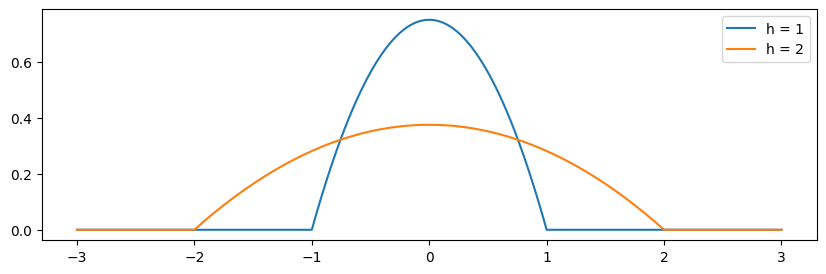

In [3]:
h = 2
x_arr = np.linspace(-3, 3, 1000)

plt.figure(figsize=(10, 3))
plt.plot(x_arr, kde.kernel_epa(x_arr), label="h = 1")
plt.plot(x_arr, (1 / h) * kde.kernel_epa(x_arr / h), label=f"h = {h}")

plt.legend()
plt.show()

### naive NW estimator

In [4]:
def nadaraya_watson(x_obs, y_obs, x_pred, kernel, h=1):
    """
    VL - Nichtparametrische Stat

    Def 4.2 Nadaraya-Watson-Schätzer

    f_{n, h}^{NW} (x) = \frac {\sum Y_i K(x-x_i)}{\sum K(x-x_i)}}

    x_obs = observation points
    y_obs = observation values
    x_pred = evaluation points
    kernel = kernel function
    h = bandwidth

    """

    y_pred = np.zeros(x_pred.shape[0])

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    # for each evaluation point

    # w = evaluate kernel function of each observation at evaluation point
    # w * y = multiply with respective y_obs
    # y_pred = w * y / sum(w)

    for i, x in enumerate(x_pred):
        
        w = kernel_func((x - x_obs) / h)
        # sum_of_w = np.sum(w)
        # if np.sum(w) is 0 then set sum_of_w to 1
        sum_of_w = np.sum(w) if (sum_of_w := np.sum(w)) != 0 else np.finfo(float).eps

        y_pred[i] = np.sum(w * y_obs / sum_of_w)

        # if value explodes, print some info
        # if np.abs(y_pred[i]) > 100:
        #     print('- '*10)
        #     print(f"y_pred = {y_pred[i]}")
        #     print(f"sum w = {np.sum(w)}")
        #     print(f"w = {np.round(w)}")
        #     print(f"y = {np.round(y_obs)}")

    return y_pred

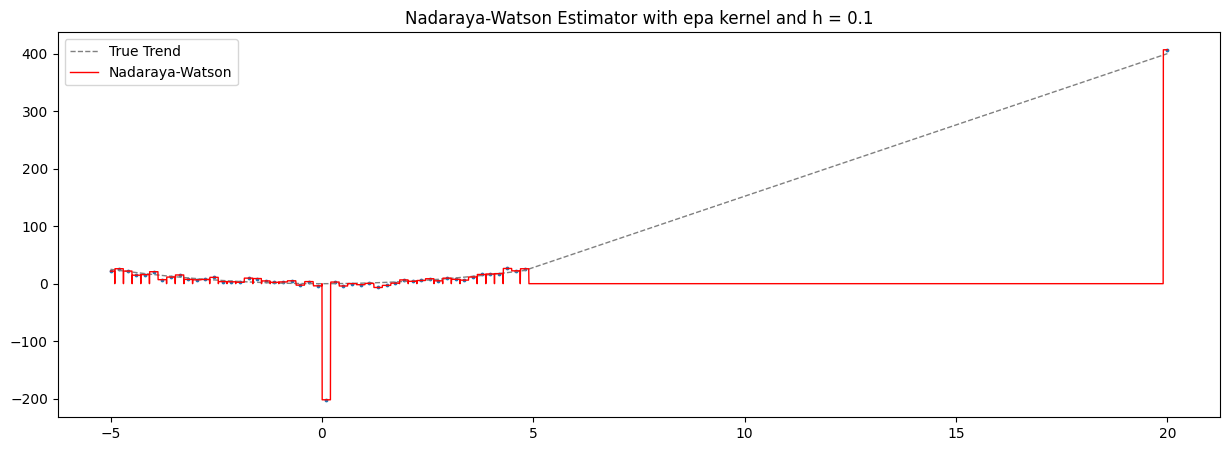

In [5]:
# simulation params
n = 50
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# add outlier to x range
x[-1] = 20

# print(f"observations at x = {x}")
y_true = x**2
y = y_true + np.random.normal(0, 3, n)
# add outlier to y range
y[n//2] -= 200

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x.min(), x.max(), n * 100)
# print(f"making NW pred at {x_pred}")

# h = 0.1 * (1/np.pi) # = 0.03183098861837907
h = 0.1
kernel = 'epa'
y_pred_nw = nadaraya_watson(x, y, x_pred, kernel, h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3)
plt.plot(x, y_true, color="grey", ls="--", lw=1, label="True Trend")
# plt.plot(x, y_pred, color="grey", ls="--", lw=1, label="Linear Regression")
plt.plot(x_pred, y_pred_nw, color="red", lw=1, label="Nadaraya-Watson")

# plt.xlim(x_min, x_max+10)
# plt.ylim(y_true.min()-10, np.sort(y_true)[1]+50)

plt.title(f"Nadaraya-Watson Estimator with {kernel} kernel and h = {h}")
plt.legend()
plt.show()

#### Question !!!

In [6]:
# what to do with sum(w) = 0 if bandwidth is small and no x are in vicinity ?
# we need to divide by sum(w) in the end, so we need to check for this case ...
# do we divide by 1 then ???

#### illustrate problem with sinc kernel

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:37: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))


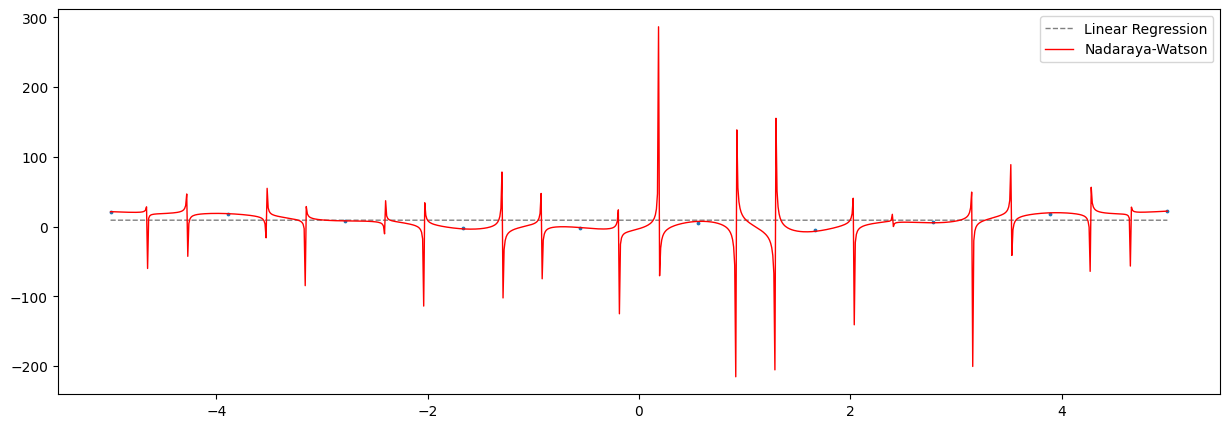

In [7]:
# simulation params
n = 10
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n * 100)
# print(f"making NW pred at {x_pred}")

# h = 0.1 * (1/np.pi) # = 0.03183098861837907
h = 0.1
y_pred_nw = nadaraya_watson(x, y, x_pred, "sinc", h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3)
plt.plot(x, y_pred, color="grey", ls="--", lw=1, label="Linear Regression")
plt.plot(x_pred, y_pred_nw, color="red", lw=1, label="Nadaraya-Watson")

plt.legend()
plt.show()

#### PROBLEM !!!

In [8]:
# PROBLEM with kernels that have negative values in naive NW estimator

# in the worst case scenario at some evaluation point x
# the kernel outputs cancel each other out in sum(K) and the sum gets really small ( in some cases even negative )
# therefore the effective weight w_i = K / sum(K) gets blown up

# even though the sum of the weights is still 1, the individual weights can get jumpy, eg :

# |  w   |  -44.0 |   2.0 |  12.0 |   1.0 |  -6.0 |  -2.0 |   4.0 |   2.0 |  -3.0 |
# |  y   |   24.0 |  10.0 |  10.0 |   9.0 |   0.0 |   5.0 |   5.0 |  17.0 |  26.0 |
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# | w*y  |  840.0 |  22.0 | 120.0 |   9.0 |   0.0 | -10.0 |  20.0 |  34.0 | -78.0 |
# | sum = 517

# therefore y_pred = sum( w_i * y_i ) gets blown up as well in both positive and negative directions

#### naive NW for diff kernels and h

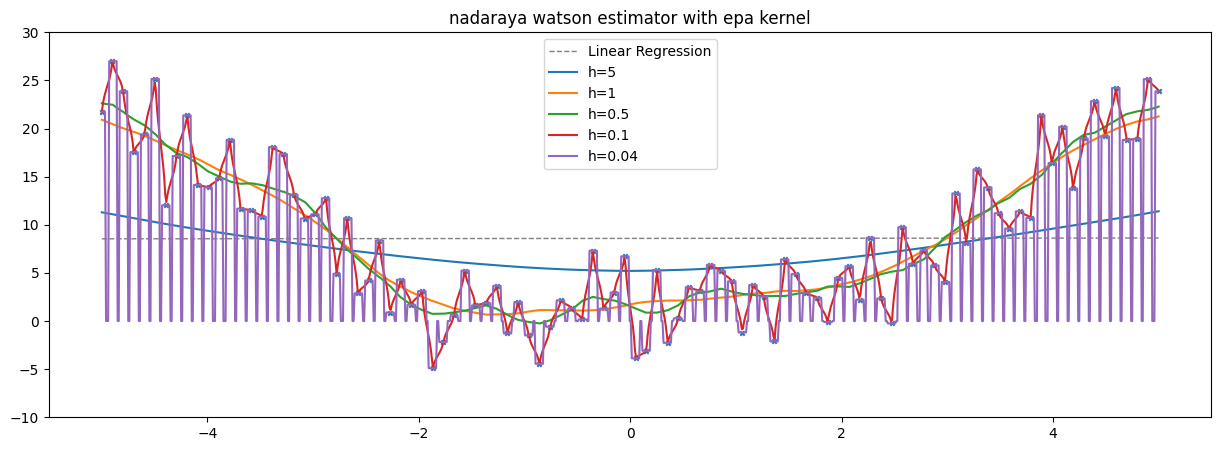

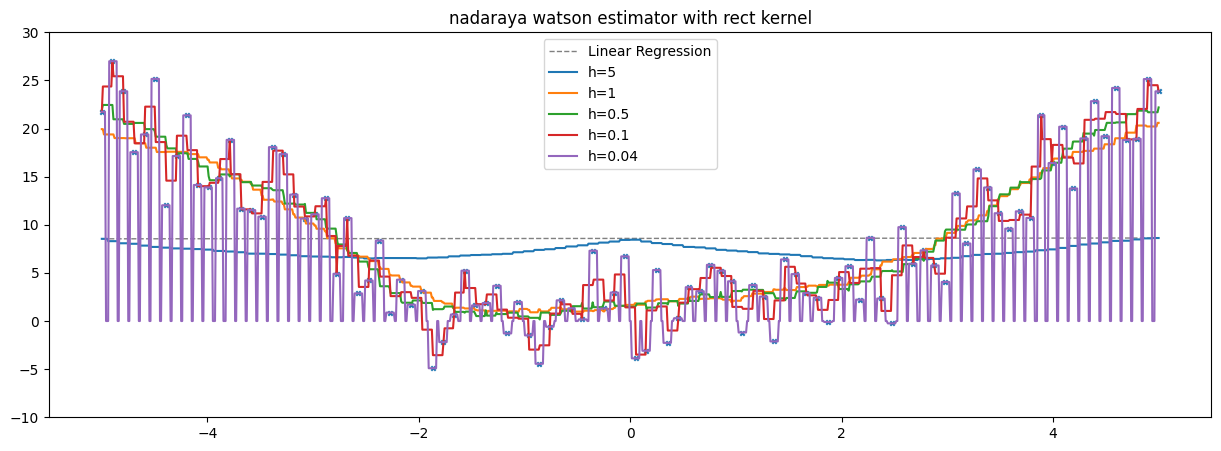

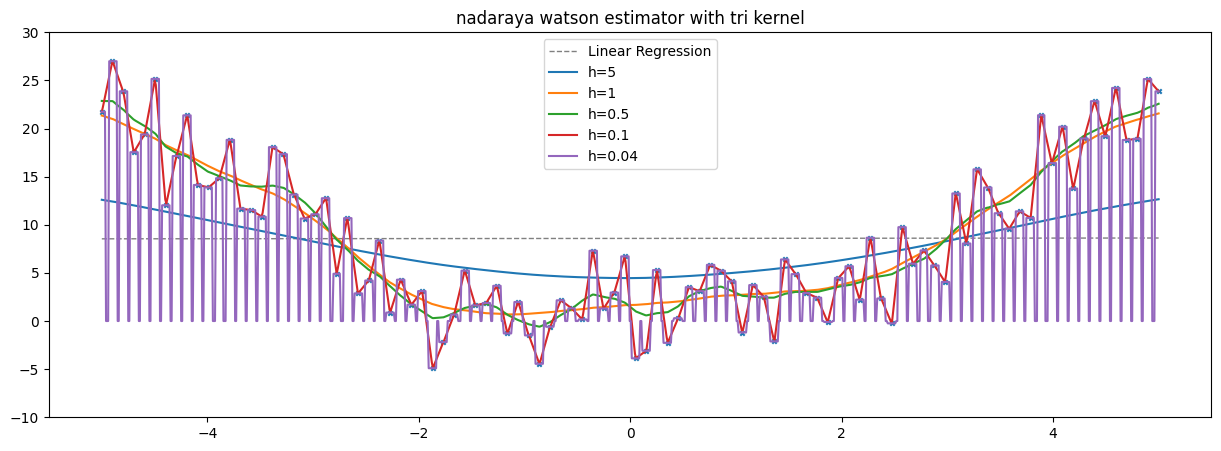

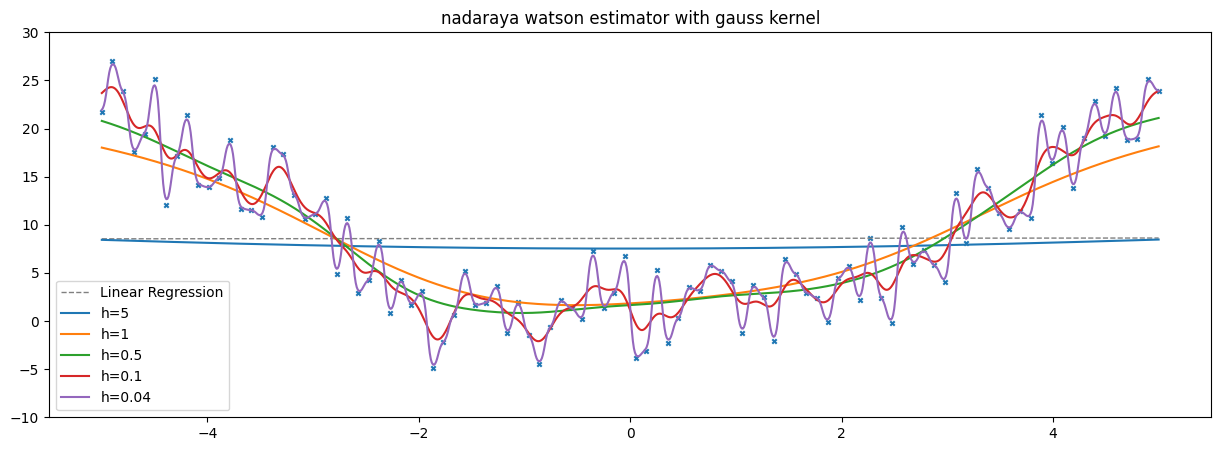

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:37: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))


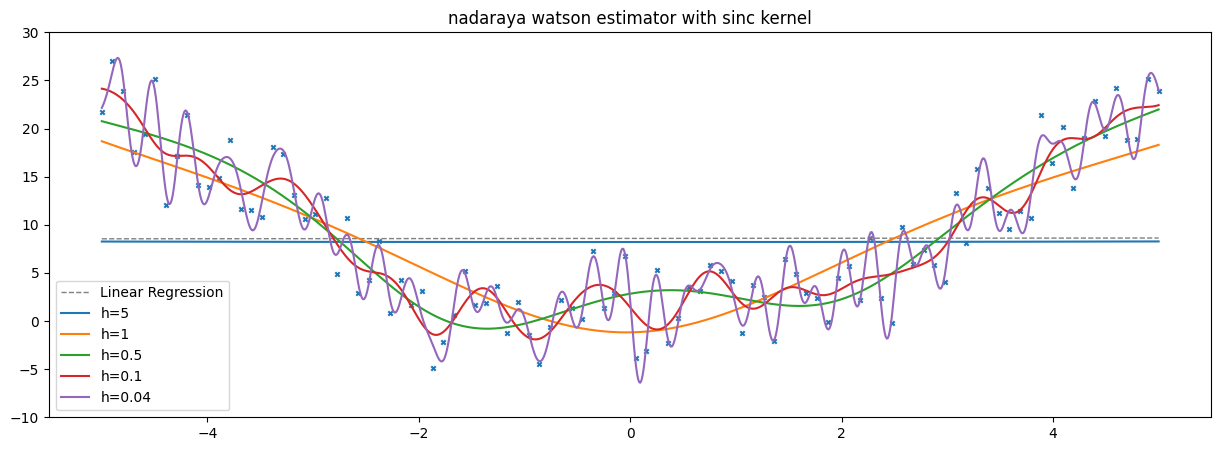

In [9]:
# simulation params
n = 100
x_min = -5
x_max = 5

# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# x = np.random.uniform(x_min, x_max, n) # random x point distribution

# fix seed
np.random.seed(123)
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n * 10)
# print(f"making NW pred at {x_pred}")

kernel_types = ["epa", "rect", "tri", "gauss", "sinc"]
h_arr = [5, 1, 0.5, 0.1, 0.04]

for kernel_type in kernel_types:
    plt.figure(figsize=(15, 5))
    plt.scatter(x, y, s=10, marker="x")
    plt.plot(x, y_pred, color="grey", ls="--", lw=1, label="Linear Regression")

    for h in h_arr:
        y_pred_nw = nadaraya_watson(x, y, x_pred, kernel_type, h=h)
        plt.plot(x_pred, y_pred_nw, lw=1.5, label=f"h={h}")

    plt.ylim(-10, 30)
    plt.title(f"nadaraya watson estimator with {kernel_type} kernel")
    plt.legend()
    plt.show()

### argmin NW estimator

In [10]:
def nadaraya_watson_argmin(x_obs, y_obs, x_pred, kernel, h=1):
    """
    VL - Nichtparametrische Stat

    Def 4.2 Nadaraya-Watson-Schätzer ... Verallgemeinerung

    ALT :
    \hat f_{n, h}^{NW} (x) = \frac {\sum Y_i K(x-x_i)}{\sum K(x-x_i)}}

    NEU :
    \hat f_{n, h}^{NW} (x) = argmin_{y \in \R} \sum^n (Y_i - y)^2 K(x - x_i)

    """

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    # for each evaluation point

    # find optimal y_opt that minimizes kernel weighted sum of squared errors
    # define loss function L(y) = sum (Y_i - y)^2 K(x - x_i)
    # run optimizer to find y_opt = argmin L(y)
    # y_pred = y_opt

    for i, x in enumerate(x_pred):
        
        if np.sum(kernel_func((x - x_obs) / h)) == 0:
            # print(f"sum of kernel weights is 0 at x = {x}")
            continue

        def loss(y):
            return np.sum((y_obs - y) ** 2 * kernel_func((x - x_obs) / h))

        y_opt = minimize(loss, 0).x
        y_pred[i] = y_opt[0]

        # if np.abs(y_pred[i]) > 100:
        #     print('- '*10)
        #     print(f"y_pred = {y_pred[i]}")
        #     print(f"sum w = {np.sum(w)}")
        #     print(f"w = {np.round(w)}")
        #     print(f"y = {np.round(y_obs)}")

    return y_pred

#### compare argmin vs naive vs lin reg

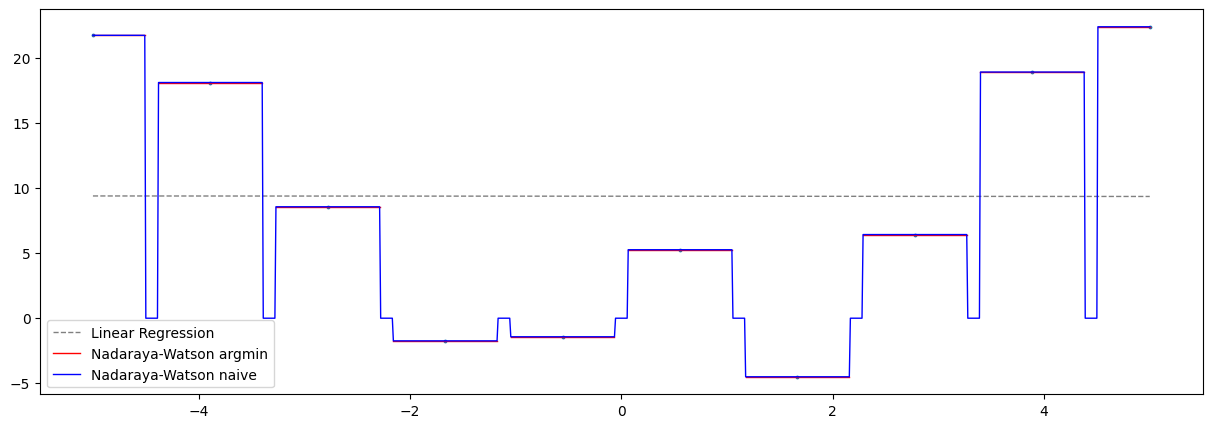

In [11]:
# simulation params
n = 10
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n * 100)
# print(f"making NW pred at {x_pred}")

h = 0.1 * (1 / np.pi)
h = 0.5
y_pred_nw_argmin = nadaraya_watson_argmin(x, y, x_pred, "rect", h=h)
y_pred_nw_naive = nadaraya_watson(x, y, x_pred, "rect", h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3)
plt.plot(x, y_pred, color="grey", ls="--", lw=1, label="Linear Regression")
plt.plot(x_pred, y_pred_nw_argmin, color="red", lw=1, label="Nadaraya-Watson argmin")
plt.plot(x_pred, y_pred_nw_naive, color="blue", lw=1, label="Nadaraya-Watson naive")

plt.legend()
plt.show()

#### argmin for diff kernels and h

In [12]:
# # simulation params
# n = 100
# x_min = -5
# x_max = 5

# # generate data using trend = x^2 and gaussian noise
# x = np.linspace(x_min, x_max, n)
# # x = np.random.uniform(x_min, x_max, n) # random x point distribution

# # fix seed
# np.random.seed(123)
# y = x**2 + np.random.normal(0, 3, n)

# # Fit Linear Regression model
# model = LinearRegression()
# model.fit(x.reshape(-1, 1), y)
# y_pred = model.predict(x.reshape(-1, 1))

# # Use Nadaraya-Watson Estimator
# x_pred = np.linspace(x_min, x_max, n * 10)
# # print(f"making NW pred at {x_pred}")

# kernel_types = ["epa", "rect", "tri", "gauss", "sinc"]
# h_arr = [5, 1, 0.5, 0.1, 0.04]

# for kernel_type in kernel_types:
#     plt.figure(figsize=(15, 5))
#     plt.scatter(x, y, s=10, marker="x")
#     plt.plot(x, y_pred, color="grey", ls="--", lw=1, label="Linear Regression")

#     for h in h_arr:
#         y_pred_nw = nadaraya_watson_argmin(x, y, x_pred, kernel_type, h=h)
#         plt.plot(x_pred, y_pred_nw, lw=1.5, label=f"h={h}")

#     plt.ylim(-10, 30)
#     plt.title(f"nadaraya watson estimator with {kernel_type} kernel")
#     plt.legend()
#     plt.show()

In [13]:
# argmin and naive version return the same results ...
# unsurprisingly ???

### local linear estimator

#### argmin loc lin estim

In [14]:
def loc_lin_estim_argmin(x_obs, y_obs, x_pred, kernel, h=1):

    """
    local linear estimator
    """

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    # for each evaluation point

    # find optimal constant and slope that minimizes kernel weighted sum of squared errors
    # define loss function L(y) = sum (Y_i - a - b*(x - x_i))^2 K(x - x_i)
    # run optimizer to find a, b = argmin L(y)
    # y_pred = a + b*(x - x_pred)
        
    # also save the slopes and intercepts
    res_a = np.zeros(x_pred.shape[0])
    res_b = np.zeros(x_pred.shape[0])

    for i, x in enumerate(x_pred):

        def loss(params):
            a, b = params
            return np.sum((y_obs - a - b*(x_obs - x)) ** 2 * kernel_func((x_obs - x) / h))
        
        # find the index of the closes observation point to x
        # and use it as initial guess for the linear regression
        idx = np.argmin(np.abs(x_obs - x))
        init_guess = [y_obs[idx], 0]
        res = minimize(loss, init_guess).x
        a, b = res
        res_a[i] = a
        res_b[i] = b

    return res_a, res_b

#### loc lin in WLS / GLS form

In [15]:
def loc_lin_estim_wls(x_obs, y_obs, x_pred, kernel, h=1):

    """
    local linear estimator
    """

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    n = x_obs.shape[0]

    # also save the slopes and intercepts
    res_a = np.zeros(x_pred.shape[0])
    res_b = np.zeros(x_pred.shape[0])

    for i, x in enumerate(x_pred):

        # create X matrix
        X = np.ones((x_obs.shape[0], 2))
        X[:, 1] = (x_obs- x) / h
        # create Kernel matrix
        K = np.diag(kernel_func((x_obs - x) / h))
        # create Y matrix
        Y = y_obs.reshape(n, 1)

        mat1_temp = np.array(X.T @ K @ X)
        
        # invert using LU decomposition ... not stable for small matrices
        # mat1 = np.linalg.inv(mat1_temp) 

        # pseudo inverse using SVD ... more stable for small matrices
        mat1 = np.linalg.pinv(mat1_temp) 
        
        matmul = mat1 @ X.T @ K @ Y
        a, b = matmul.flatten()
        
        res_a[i] = a
        res_b[i] = b
    
    return res_a, (res_b)

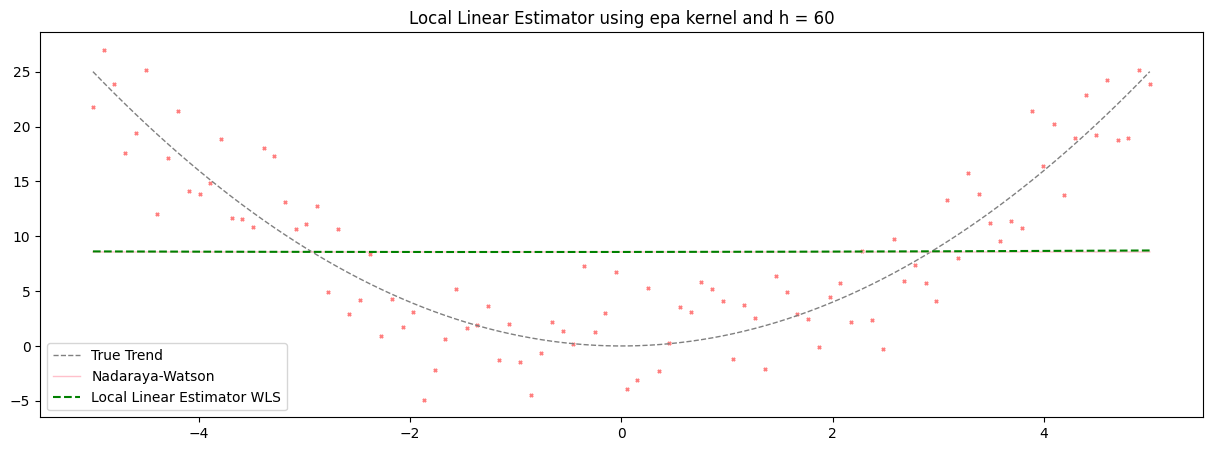

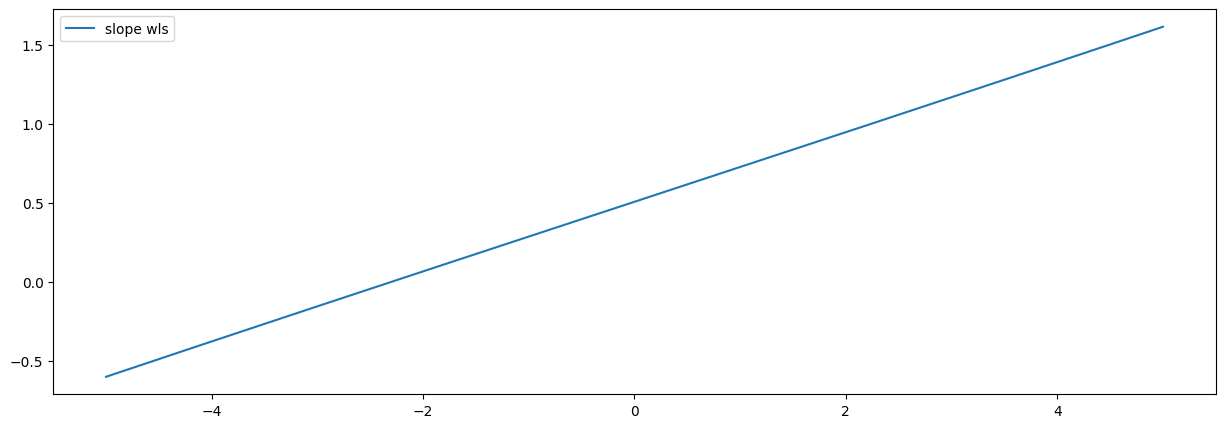

In [16]:
# simulation params
n = 100
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y_true = x**2
y = y_true + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n * 100)
# print(f"making NW pred at {x_pred}")

h = 0.1 * (1 / np.pi)
h = 60
kernel = 'epa'
y_pred_nw = nadaraya_watson(x, y, x_pred, kernel, h=h)
# y_pred_ll_argmin, weights_argmin = loc_lin_estim_argmin(x, y, x_pred, "rect", h=h)
y_pred_ll_wls, weights_wls = loc_lin_estim_wls(x, y, x_pred, kernel, h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=5, marker='x', c='red', alpha=0.5)
plt.plot(x, y_true, color="grey", ls="--", lw=1, label="True Trend")
plt.plot(x_pred, y_pred_nw, color="pink", lw=1, label="Nadaraya-Watson")
# plt.plot(x_pred, y_pred_ll_argmin, color="blue", lw=1.5, ls='-.', label="Local Linear Estimator argmin")
plt.plot(x_pred, y_pred_ll_wls, color="green", lw=1.5, ls='--', label="Local Linear Estimator WLS")
plt.title(f"Local Linear Estimator using {kernel} kernel and h = {h}")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
# plt.plot(x_pred, weights_argmin, label="slope argmin")
plt.plot(x_pred, weights_wls, label="slope wls")

plt.legend()
plt.show()

In [18]:
# # simulation params
# n = 15
# x_min = -5
# x_max = 5

# np.random.seed(123)
# # generate data using trend = x^2 and gaussian noise
# x = np.linspace(x_min, x_max, n)
# # print(f"observations at x = {x}")
# y = x**2 + np.random.normal(0, 3, n)

# # Fit Linear Regression model
# model = LinearRegression()
# model.fit(x.reshape(-1, 1), y)
# y_pred = model.predict(x.reshape(-1, 1))

# # Use Nadaraya-Watson Estimator
# x_pred = np.linspace(x_min, x_max, n * 100)
# # print(f"making NW pred at {x_pred}")

# h = 0.1 * (1 / np.pi)
# h = 0.5
# y_pred_nw = nadaraya_watson(x, y, x_pred, "rect", h=h)
# y_pred_ll_argmin, weights_argmin = loc_lin_estim_argmin(x, y, x_pred, "rect", h=h)
# y_pred_ll_wls, weights_wls = loc_lin_estim_wls(x, y, x_pred, "rect", h=h)

# # Plot the original data and the regression line
# plt.figure(figsize=(15, 5))
# plt.scatter(x, y, s=20, marker='x', c='red')
# plt.plot(x, y_pred, color="grey", ls="--", lw=1, label="Linear Regression")
# plt.plot(x_pred, y_pred_nw, color="pink", lw=1, label="Nadaraya-Watson")
# plt.plot(x_pred, y_pred_ll_argmin, color="blue", lw=1.5, ls='-.', label="Local Linear Estimator argmin")
# plt.plot(x_pred, y_pred_ll_wls, color="green", lw=1.5, ls='--', label="Local Linear Estimator WLS")

# plt.legend()
# plt.show()

# plt.figure(figsize=(15, 5))
# plt.plot(x_pred, -weights_argmin[1], label="slope argmin")
# plt.plot(x_pred, -weights_wls[1], label="slope wls")
# plt.show()

### argmin local polynomial estim of higher orders ...

In [19]:
def loc_quad_estim_wls(x_obs, y_obs, x_pred, kernel, h=1):

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    n = x_obs.shape[0]

    # also save the slopes and intercepts
    res_a = np.zeros(x_pred.shape[0])
    res_b = np.zeros(x_pred.shape[0])
    res_c = np.zeros(x_pred.shape[0])

    for i, x in enumerate(x_pred):

        # create X matrix
        X = np.ones((x_obs.shape[0], 3))
        X[:, 1] = (x_obs- x) / h
        X[:, 2] = (x_obs- x) ** 2 / h**2
        # create Kernel matrix
        K = np.diag(kernel_func((x_obs - x) / h))
        # create Y matrix
        Y = y_obs.reshape(n, 1)

        mat1_temp = np.array(X.T @ K @ X)
        
        # invert using LU decomposition ... not stable for small matrices
        # mat1 = np.linalg.inv(mat1_temp) 

        # pseudo inverse using SVD ... more stable for small matrices
        mat1 = np.linalg.pinv(mat1_temp) 
        
        matmul = mat1 @ X.T @ K @ Y
        a, b, c = matmul.flatten()
        
        res_a[i] = a
        res_b[i] = b
        res_c[i] = c
    
    return res_a, (res_b, res_c)

In [20]:
def loc_cubic_estim_wls(x_obs, y_obs, x_pred, kernel, h=1):

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    n = x_obs.shape[0]

    # also save the slopes and intercepts
    res_a = np.zeros(x_pred.shape[0])
    res_b = np.zeros(x_pred.shape[0])
    res_c = np.zeros(x_pred.shape[0])
    res_d = np.zeros(x_pred.shape[0])

    for i, x in enumerate(x_pred):

        # create X matrix
        X = np.ones((x_obs.shape[0], 4))
        X[:, 1] = (x_obs- x) / h
        X[:, 2] = (x_obs- x) ** 2 / h**2
        X[:, 3] = (x_obs- x) ** 3 / h**3
        # create Kernel matrix
        K = np.diag(kernel_func((x_obs - x) / h))
        # create Y matrix
        Y = y_obs.reshape(n, 1)

        mat1_temp = np.array(X.T @ K @ X)
        
        # invert using LU decomposition ... not stable for small matrices
        # mat1 = np.linalg.inv(mat1_temp) 

        # pseudo inverse using SVD ... more stable for small matrices
        mat1 = np.linalg.pinv(mat1_temp) 
        
        matmul = mat1 @ X.T @ K @ Y
        a, b, c, d = matmul.flatten()
        
        res_a[i] = a
        res_b[i] = b
        res_c[i] = c
        res_d[i] = d
    
    return res_a, (res_b, res_c, res_d)

In [21]:
def loc_cubic_estim_argmin(x_obs, y_obs, x_pred, kernel, h=1):

    """
    local quadratic estimator
    """

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    # save mean and derivative estimates
    res_a = np.zeros(x_pred.shape[0])
    res_b = np.zeros(x_pred.shape[0])
    res_c = np.zeros(x_pred.shape[0])
    res_d = np.zeros(x_pred.shape[0])

    for i, x in enumerate(x_pred):
        
        def loss(params):
            a, b, c, d = params
            return np.sum((y_obs - a - b*(x_obs-x) - c*(x_obs-x)**2 - d*(x_obs-x)**2) ** 2 * kernel_func((x_obs-x) / h))
        
        # find the index of the closes observation point to x
        # and use it as initial guess for the linear regression
        idx = np.argmin(np.abs(x_obs - x))
        init_guess = [y_obs[idx], 0, 0, 0]

        res = minimize(loss, init_guess).x
        a, b, c, d = res
        res_a[i] = a
        res_b[i] = b
        res_c[i] = c
        res_d[i] = d

    return res_a, res_b, res_c, res_d

In [ ]:
def loc_quad_estim_argmin(x_obs, y_obs, x_pred, kernel, h=1):

    """
    local quadratic estimator
    """

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan

    if kernel == "epa":
        kernel_func = kde.kernel_epa
    if kernel == "gauss":
        kernel_func = kde.kernel_gauss
    if kernel == "rect":
        kernel_func = kde.kernel_rect
    if kernel == "tri":
        kernel_func = kde.kernel_tri
    if kernel == "sinc":
        kernel_func = kde.kernel_sinc

    # save mean and derivative estimates
    res_a = np.zeros(x_pred.shape[0])
    res_b = np.zeros(x_pred.shape[0])
    res_c = np.zeros(x_pred.shape[0])

    for i, x in enumerate(x_pred):
        
        def loss(params):
            a, b, c = params
            return np.sum((y_obs - a - b*(x_obs-x) - c*(x_obs-x)**2) ** 2 * kernel_func((x_obs-x) / h))
        
        # find the index of the closes observation point to x
        # and use it as initial guess for the linear regression
        idx = np.argmin(np.abs(x_obs - x))
        init_guess = [y_obs[idx], 0, 0]

        res = minimize(loss, init_guess).x
        a, b, c = res
        res_a[i] = a
        res_b[i] = b
        res_c[i] = c

    return res_a, res_b, res_c

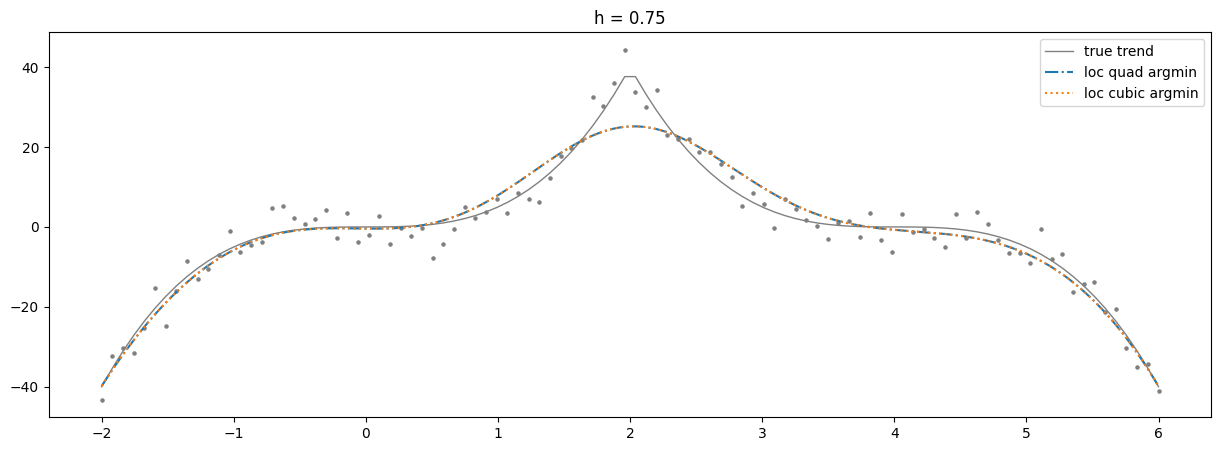

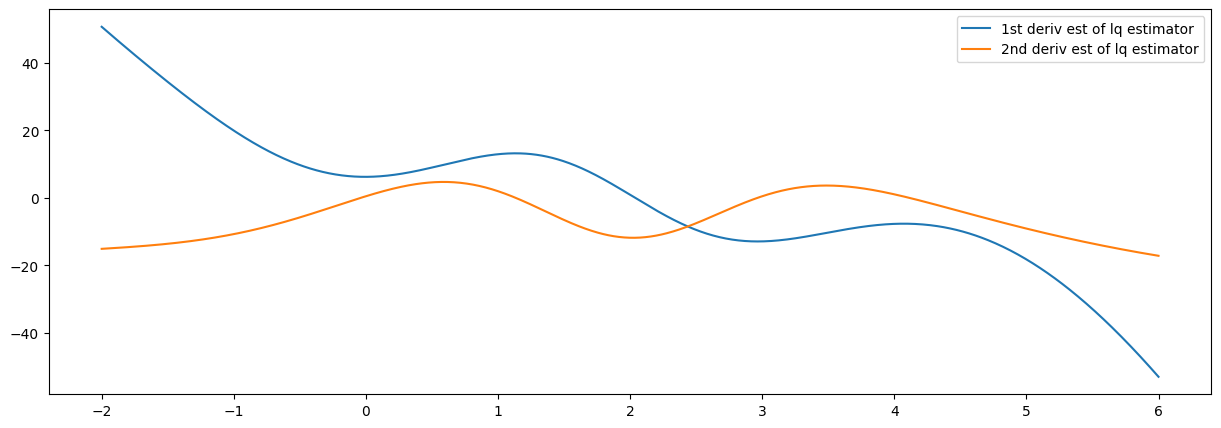

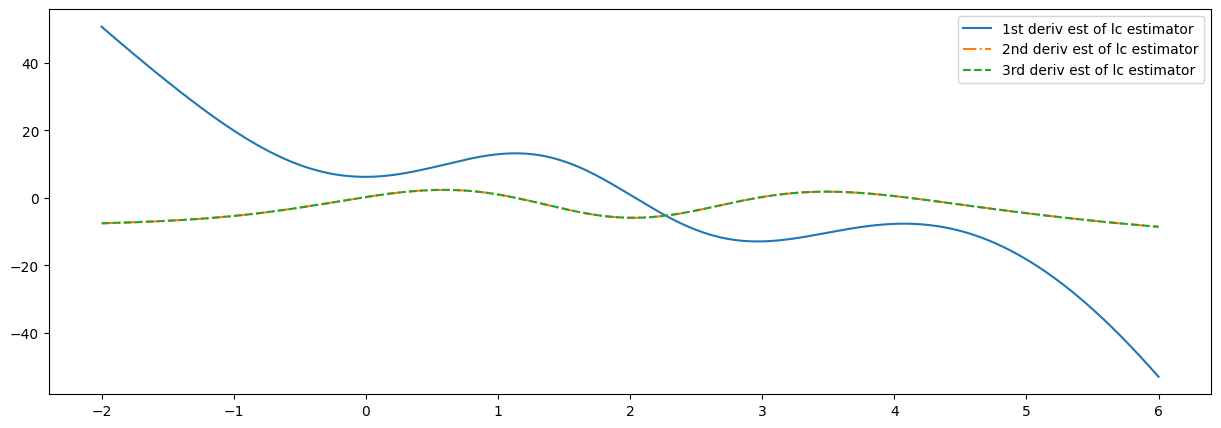

In [ ]:
# simulation params
n = 100
np.random.seed(123)

# generate data on fixed grid
x_min, x_max = -2, 6
x = np.linspace(x_min, x_max, n)
# predict on finer grid
x_pred = np.linspace(x_min, x_max, n*10)

# define trend 
y_true = 5 * np.sin(2*x) + 15
# define piecewise trend, x**3 on [-5, 0] and -x**3 on [0, 5]
y_true = 5 * np.where(x < 2, x**3, -(x-4)**3)

# add gaussian noise
y = y_true + np.random.normal(0, 3, n)

h_param = 0.75
y_pred_lq_argmin, b_lq, c_lq = loc_quad_estim_argmin(x, y, x_pred, "gauss", h=h_param)
y_pred_lc_argmin, b_lc , c_lc, d_lc = loc_cubic_estim_argmin(x, y, x_pred, "gauss", h=h_param)

# plot conditional mean estimates
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=5, c='grey', marker="o")
plt.plot(x, y_true, lw=1, c='grey', label="true trend")
plt.plot(x_pred, y_pred_lq_argmin, lw=1.5, label="loc quad argmin", ls='-.')
plt.plot(x_pred, y_pred_lc_argmin, lw=1.5, label="loc cubic argmin", ls=':')

plt.title(f"h = {h_param}")
plt.legend()
plt.show()

# plot derivative estimates
plt.figure(figsize=(15, 5))
plt.plot(x_pred, b_lq, label="1st deriv est of lq estimator")
plt.plot(x_pred, c_lq, label="2nd deriv est of lq estimator")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(x_pred, b_lc, label="1st deriv est of lc estimator", ls='-')
plt.plot(x_pred, c_lc, label="2nd deriv est of lc estimator", ls='-.')
plt.plot(x_pred, d_lc, label="3rd deriv est of lc estimator", ls='--')
plt.legend()
plt.show()

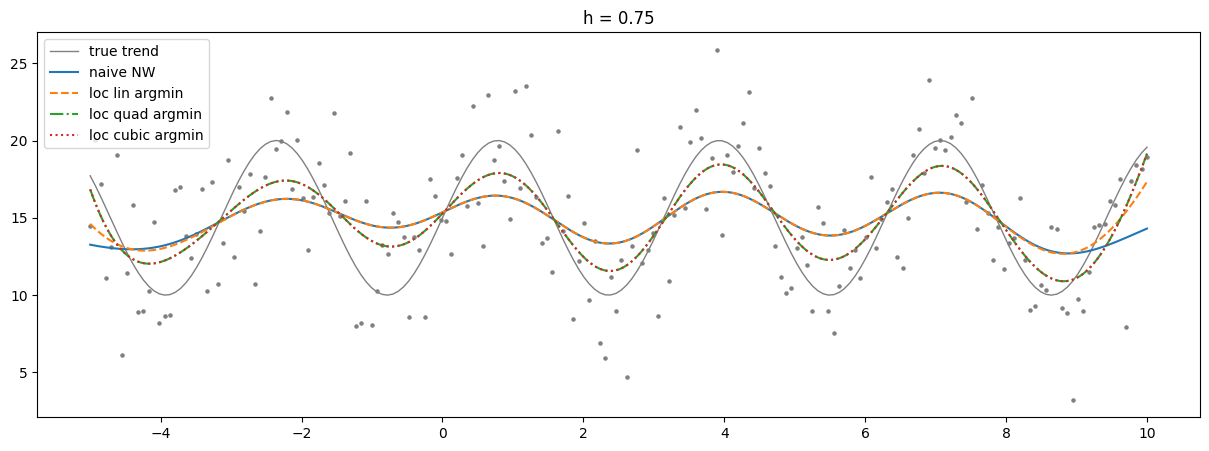

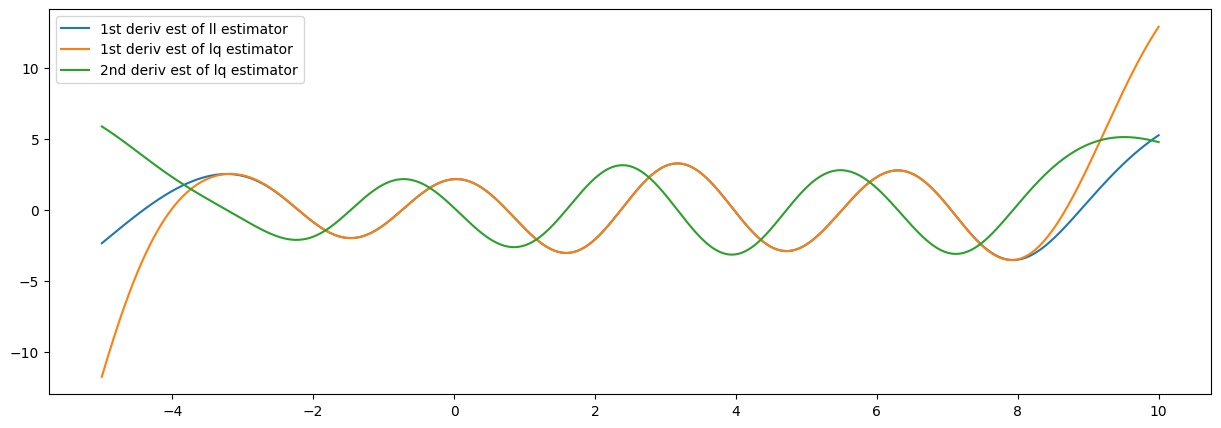

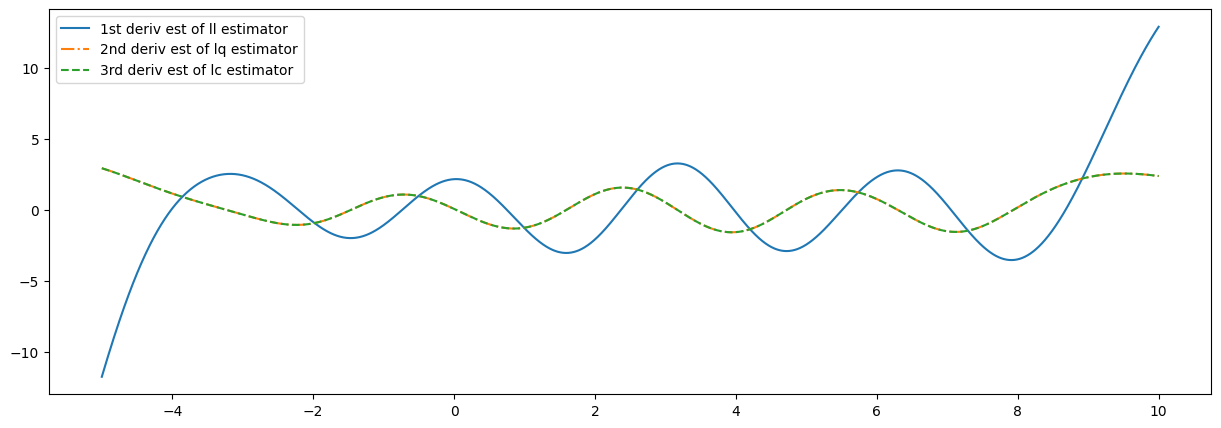

In [ ]:
# simulation params
n = 200
x_min, x_max = -5, 10

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
x_pred = np.linspace(x_min, x_max, n*10)

y_true = 5 * np.sin(2*x) + 15
y = y_true + np.random.normal(0, 3, n)

h_param = 0.75
y_pred_nw = nadaraya_watson(x, y, x_pred, "gauss", h=h_param)
y_pred_ll_argmin, b_ll = loc_lin_estim_argmin(x, y, x_pred, "gauss", h=h_param)
y_pred_lq_argmin, b_lq, c_lq = loc_quad_estim_argmin(x, y, x_pred, "gauss", h=h_param)
y_pred_lc_argmin, b_lc , c_lc, d_lc = loc_cubic_estim_argmin(x, y, x_pred, "gauss", h=h_param)

# plot conditional mean estimates
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=5, c='grey', marker="o")
plt.plot(x, y_true, lw=1, c='grey', label="true trend")

plt.plot(x_pred, y_pred_nw, lw=1.5, label="naive NW", ls='-')
plt.plot(x_pred, y_pred_ll_argmin, lw=1.5, label="loc lin argmin", ls='--')
plt.plot(x_pred, y_pred_lq_argmin, lw=1.5, label="loc quad argmin", ls='-.')
plt.plot(x_pred, y_pred_lc_argmin, lw=1.5, label="loc cubic argmin", ls=':')

plt.title(f"h = {h_param}")
plt.legend()
plt.show()

# plot derivative estimates
plt.figure(figsize=(15, 5))
plt.plot(x_pred, b_ll, label="1st deriv est of ll estimator")
plt.plot(x_pred, b_lq, label="1st deriv est of lq estimator")
plt.plot(x_pred, c_lq, label="2nd deriv est of lq estimator")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(x_pred, b_lc, label="1st deriv est of lc estimator", ls='-')
plt.plot(x_pred, c_lc, label="2nd deriv est of lc estimator", ls='-.')
plt.plot(x_pred, d_lc, label="3rd deriv est of lc estimator", ls='--')
plt.legend()
plt.show()

### Compare own methods with statsmodels

In [34]:
# simulation params
n = 500
# x_min = -5
# x_max = 5
# x = np.linspace(x_min, x_max, n)
# sample x from normal distribution
x = np.random.normal(0, 1, n)
x = np.sort(x)
x_min = x.min()
x_max = x.max()

# generate data using trend = x^2 and gaussian noise
np.random.seed(123)
y_true = x**2
y_true = 10 * np.sin(2*x) + 20
y = y_true + np.random.normal(0, 3, n)

x_pred = np.linspace(x_min, x_max, n * 10)

h = 0.1 * (1 / np.pi)
h = 1
kernel = 'epa'
y_pred_nw = nadaraya_watson(x, y, x_pred, kernel, h=h)
y_pred_ll_wls, weights_wls = loc_lin_estim_wls(x, y, x_pred, kernel, h=h)
y_pred_lquad_wls, weights_quad_wls = loc_quad_estim_wls(x, y, x_pred, kernel, h=h)
y_pred_lcubic_wls, weights_cubic_wls = loc_cubic_estim_wls(x, y, x_pred, kernel, h=h)

true error of NW estimator = 13.597161118383008
true error of LL estimator = 3.5197757303954758
true error of LQuad estimator = 0.4277007209798646
true error of LCubic estimator = 1.9962158560166698


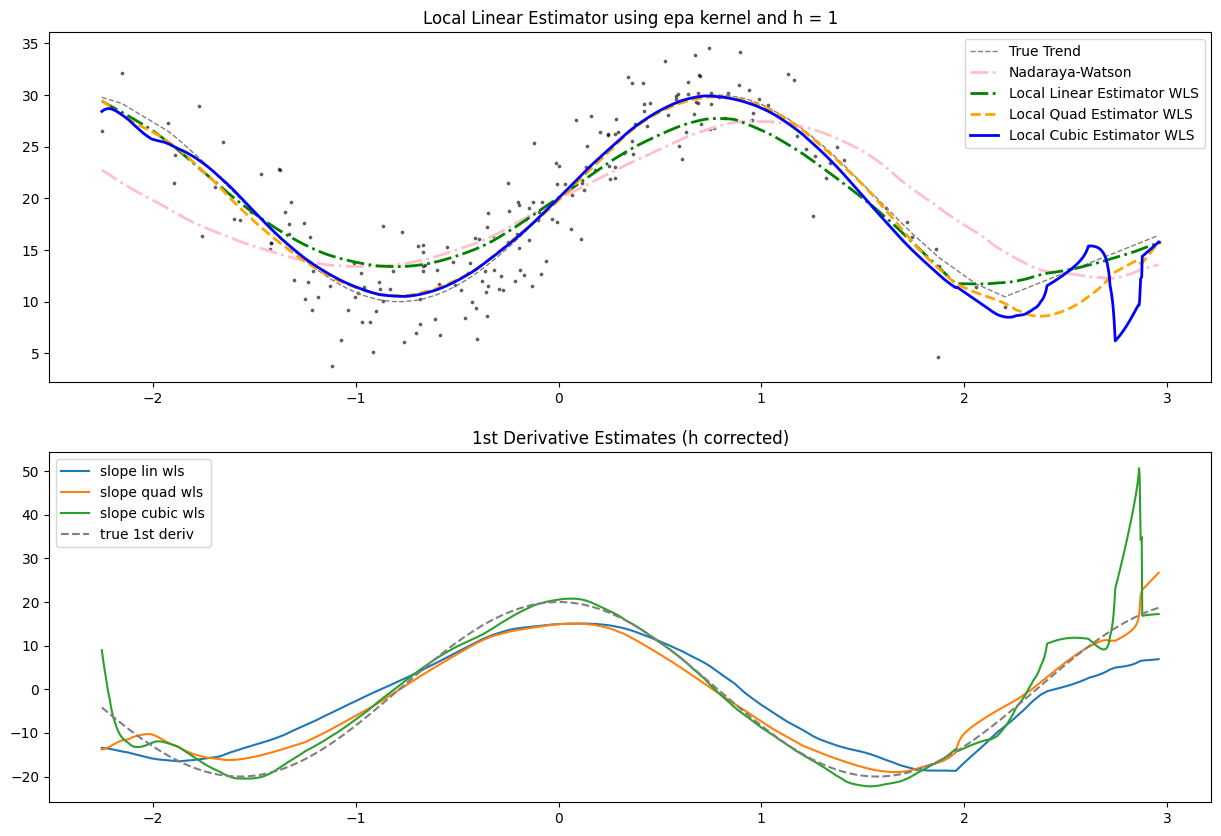

In [33]:
y_pred_true = 10 * np.sin(2*x_pred) + 20
# true error of the estimates
print(f"true error of NW estimator = {np.mean((y_pred_nw - y_pred_true)**2)}")
print(f"true error of LL estimator = {np.mean((y_pred_ll_wls - y_pred_true)**2)}")
print(f"true error of LQuad estimator = {np.mean((y_pred_lquad_wls - y_pred_true)**2)}")
print(f"true error of LCubic estimator = {np.mean((y_pred_lcubic_wls - y_pred_true)**2)}")

# Plot the original data and the regression line
fig, axes = plt.subplots(2,1,figsize=(15, 10))
ax1, ax2 = axes

ax1.scatter(x, y, s=3, marker='o', c='black', alpha=0.5)
ax1.plot(x, y_true, color="grey", ls="--", lw=1, label="True Trend")

ax1.plot(x_pred, y_pred_nw, color="pink", lw=2, ls='-.', label="Nadaraya-Watson")
ax1.plot(x_pred, y_pred_ll_wls, color="green", lw=2, ls='-.', label="Local Linear Estimator WLS")
ax1.plot(x_pred, y_pred_lquad_wls, color="orange", lw=2, ls='--', label="Local Quad Estimator WLS")
ax1.plot(x_pred, y_pred_lcubic_wls, color="blue", lw=2, ls='-', label="Local Cubic Estimator WLS")

ax1.set_title(f"Local Linear Estimator using {kernel} kernel and h = {h}")
ax1.legend()

ax2.plot(x_pred, weights_wls/h, label="slope lin wls")
ax2.plot(x_pred, weights_quad_wls[0]/h, label="slope quad wls")
ax2.plot(x_pred, weights_cubic_wls[0]/h, label="slope cubic wls")
# plot true derivative of y_true = 10 * np.sin(2*x) + 20
ax2.plot(x_pred, 20 * np.cos(2*x_pred), ls='--', c='grey', label="true 1st deriv")

ax2.legend()
ax2.set_title("1st Derivative Estimates (h corrected)")

plt.show()

#### loc const


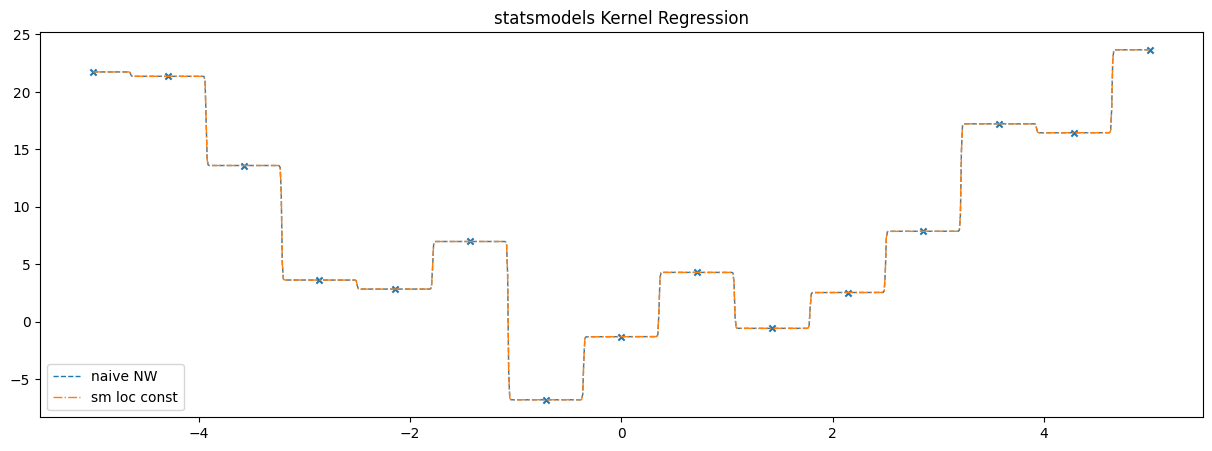

In [73]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# simulation params
n = 15
x_min, x_max = -5, 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
x_pred = np.linspace(x_min, x_max, n * 100)
y = x**2 + np.random.normal(0, 3, n)

h_param = 0.05
y_pred_nw = nadaraya_watson(x, y, x_pred, "gauss", h=h_param)
y_pred_sm_lc = KernelReg(y, x, var_type="c", reg_type="lc", ckertype="gaussian", bw=[h_param]).fit(x_pred)[0]

# distinguish between local constant and local linear regression
# !!! only has gaussian kernel for continuous variables !!!

plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=20, marker="x")

plt.plot(x_pred, y_pred_nw, lw=1, label="naive NW", ls='--')
plt.plot(x_pred, y_pred_sm_lc, lw=1, label="sm loc const", ls='-.')

plt.title(f"statsmodels Kernel Regression")
plt.legend()
plt.show()

# WE see that they are the SAME !!!

#### loc lin

In [79]:
# from statsmodels.nonparametric.kernel_regression import KernelReg

# # simulation params
# n = 150
# x_min, x_max = -5, 5

# np.random.seed(123)
# # generate data using trend = x^2 and gaussian noise
# x = np.linspace(x_min, x_max, n)
# x_pred = np.linspace(x_min, x_max, n * 10)
# y = x**2 + np.random.normal(0, 3, n)

# h_params = [0.5, 0.75, 1, 1.5]

# for h_param in h_params:

#     y_pred_ll_wls, _ = loc_lin_estim_wls(x, y, x_pred, "gauss", h=h_param)
#     y_pred_ll_argmin, _ = loc_lin_estim_argmin(x, y, x_pred, "gauss", h=h_param)
#     y_pred_sm_ll = KernelReg(y, x, var_type="c", reg_type="ll", ckertype="gaussian", bw=[h_param]).fit(x_pred)[0]

#     # distinguish between local constant and local linear regression
#     # !!! only has gaussian kernel for continuous variables !!!

#     plt.figure(figsize=(15, 5))
#     plt.scatter(x, y, s=20, marker="x")

#     plt.plot(x_pred, x_pred**2, lw=1, c='black', label="true trend")
#     plt.plot(x_pred, y_pred_sm_ll, lw=1, label="sm loc linear", )
#     plt.plot(x_pred, y_pred_ll_wls, lw=1, label="loc linear wls", ls='--')
#     plt.plot(x_pred, y_pred_ll_argmin, lw=1, label="loc linear argmin", ls='-.')

#     plt.title(f"h = {h_param}")
#     plt.legend()
#     plt.show()

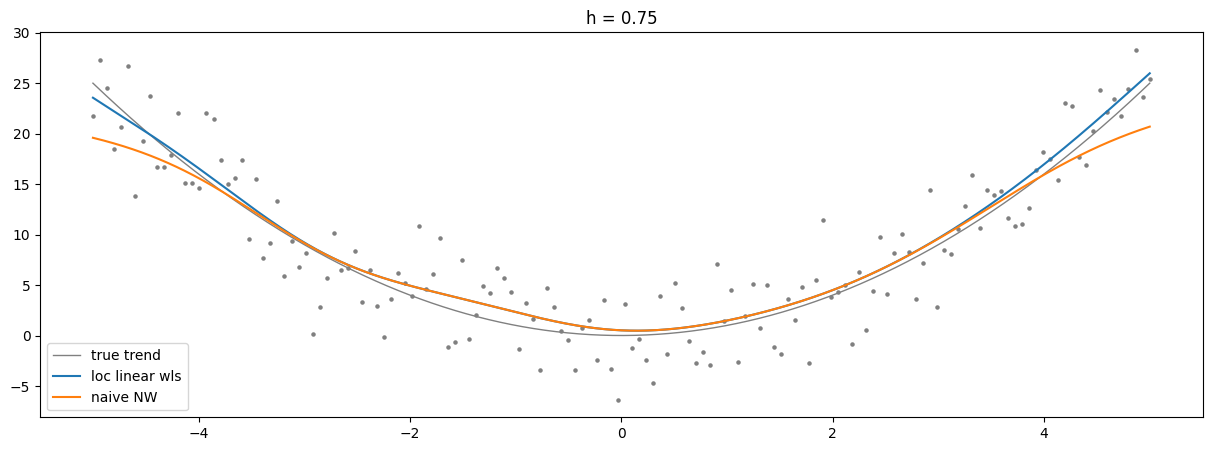

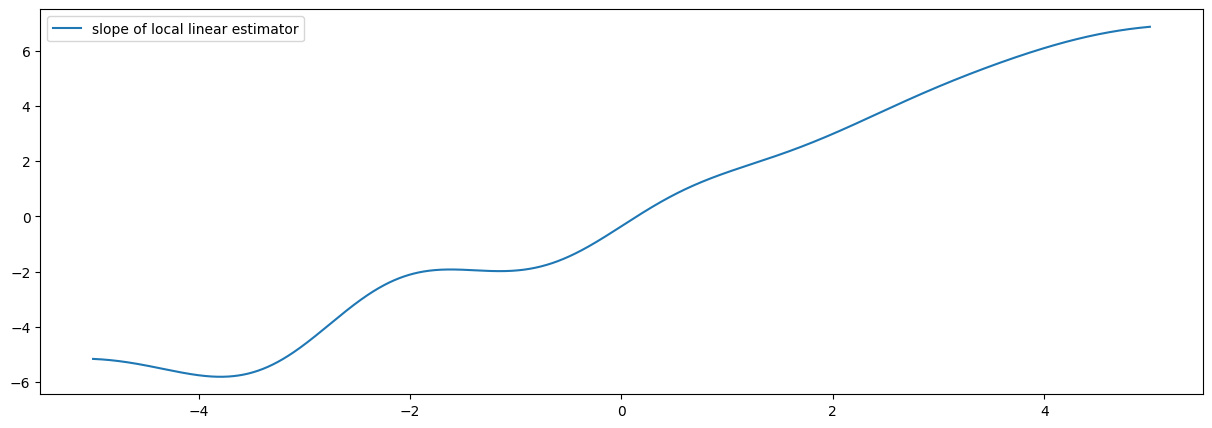

In [142]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# simulation params
n = 150
x_min, x_max = -5, 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
x_pred = np.linspace(x_min, x_max, n * 10)
y = x**2 + np.random.normal(0, 3, n)

h_param = 0.75
y_pred_nw = nadaraya_watson(x, y, x_pred, "gauss", h=h_param)
y_pred_ll_wls, _ = loc_lin_estim_wls(x, y, x_pred, "gauss", h=h_param)

# plot
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=5, c='grey', marker="o")
plt.plot(x_pred, x_pred**2, lw=1, c='grey', label="true trend")

plt.plot(x_pred, y_pred_ll_wls, lw=1.5, label="loc linear wls", ls='-')
plt.plot(x_pred, y_pred_nw, lw=1.5, label="naive NW", ls='-')

plt.title(f"h = {h_param}")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(x_pred, _, label="slope of local linear estimator")
plt.legend()
plt.show()

#### loc quad

In [1]:
y_true = x**2

y_mid = len(y_true)//2
window_len = 2
height = 5

# Create spike at the middle of the true trend
# rise = np.linspace(0, height, window_len+1)
# fall = np.linspace(height, 0, window_len+1)[1:]
# spike = np.concatenate((rise, fall))

# Create a smooth peak at the middle of the true trend
sigma = 0.2
peak = height * np.exp(-(x - x[y_mid])**2 / (2 * sigma**2))[y_mid-window_len : y_mid+window_len+1]

y_true[y_mid-window_len : y_mid+window_len+1] = peak

NameError: name 'x' is not defined

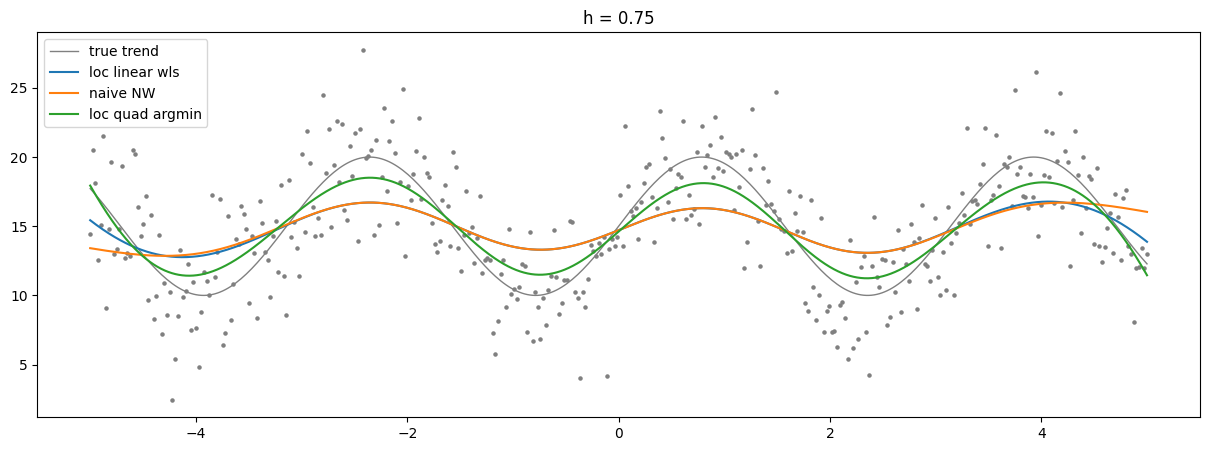

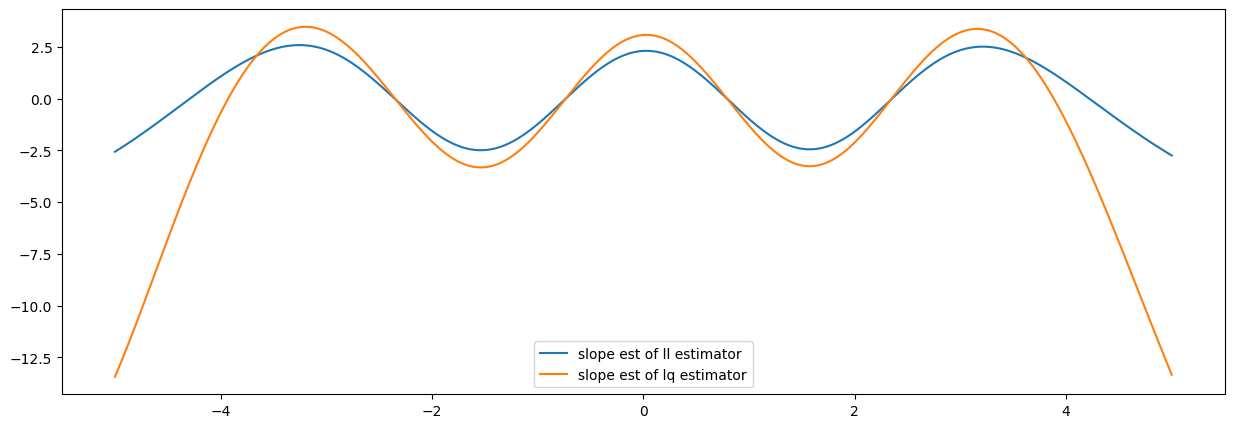

In [149]:
# simulation params
n = 400
x_min, x_max = -5, 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
x_pred = np.linspace(x_min, x_max, n*10)

y_true = 5 * np.sin(2*x) + 15
y = y_true + np.random.normal(0, 3, n)

h_param = 0.75
y_pred_nw = nadaraya_watson(x, y, x_pred, "gauss", h=h_param)
y_pred_ll_wls, b_ll = loc_lin_estim_wls(x, y, x_pred, "gauss", h=h_param)
y_pred_lq_argmin, b_lq , c_lq = loc_quad_estim_argmin(x, y, x_pred, "gauss", h=h_param)

# plot
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=5, c='grey', marker="o")
plt.plot(x, y_true, lw=1, c='grey', label="true trend")

plt.plot(x_pred, y_pred_ll_wls, lw=1.5, label="loc linear wls", ls='-')
plt.plot(x_pred, y_pred_nw, lw=1.5, label="naive NW", ls='-')
plt.plot(x_pred, y_pred_lq_argmin, lw=1.5, label="loc quad argmin", ls='-')

plt.title(f"h = {h_param}")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(x_pred, b_ll, label="slope est of ll estimator")
plt.plot(x_pred, b_lq, label="slope est of lq estimator")
plt.legend()
plt.show()

### TODO : MISE ?